In [12]:
import sys
print ("Python version: " + sys.version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Loading dataset labeled "E-commerce Sales Report" 
# Link: 
import time
time_begin = time.time()

df = pd.read_csv("C:\Data Analyst Portfolio\ShopX\E-commerce_Sale_Report_cleaned.csv")

print(f'Run time: {round(((time.time()-time_begin)/60), 3)} mins') 

Python version: 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]
Run time: 0.024 mins


In [13]:
# Now let's analyze the cancelled order data and find out what exactly is the root cause of cancellation

cancelled_df = df[df["is_cancelled"] == True]
cancelled_df.head()


,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,Amount,ship-city,ship-state,ship-postal-code,promotion-ids,B2B,gross_revenue,is_cancelled,is_delivered,order_month
0,405-8078784-5731545,30/4/2022,CANCELLED,MERCHANT,Amazon.in,STANDARD,SET389,SET389-KR-NP-S,SET,S,B09KXVBD7Z,NaN,0,647.62,MUMBAI,MAHARASHTRA,400081.00,NaN,False,0.00,True,False,2022-04
3,403-9615377-8133951,30/4/2022,CANCELLED,MERCHANT,Amazon.in,STANDARD,J0341,J0341-DR-L,WESTERN DRESS,L,B099NRCT7B,NaN,0,753.33,PUDUCHERRY,PUDUCHERRY,605008.00,NaN,False,0.00,True,False,2022-04
8,407-5443024-5233168,30/4/2022,CANCELLED,AMAZON,Amazon.in,EXPEDITED,SET200,SET200-KR-NP-A-XXXL,SET,3XL,B08L91ZZXN,CANCELLED,0,NaN,HYDERABAD,TELANGANA,500008.00,IN Core Free Shipping 2015/04/08 23-48-5-108,False,NaN,True,False,2022-04
23,404-6019946-2909948,30/4/2022,CANCELLED,MERCHANT,Amazon.in,STANDARD,SET291,SET291-KR-PP-M,SET,M,B099NK55YG,NaN,0,570.48,PUNE,MAHARASHTRA,411044.00,NaN,False,0.00,True,False,2022-04
29,404-5933402-8801952,30/4/2022,CANCELLED,MERCHANT,Amazon.in,STANDARD,JNE2132,JNE2132-KR-398-XXXL,KURTA,3XL,B07JG3CND8,NaN,0,NaN,GUWAHATI,ASSAM,781003.00,NaN,False,NaN,True,False,2022-04


In [14]:
%pip install --upgrade numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# Hypothesis: The state Maharastra has the highest cancellation of orders but it might be because it is the biggest state
# To test this out, we will find out the rate of cancellation for each state instead:

# Calculates total orders and the percentage of cancelled orders per state
state_analysis = df.groupby('ship-state')['is_cancelled'].agg(
    Total_Orders='count', 
    Cancel_Rate='mean' # Mean of a boolean gives the percentage rate
).sort_values('Total_Orders', ascending=False)

# Format as percentage for readability
state_analysis['Cancel_Rate'] = (state_analysis['Cancel_Rate'] * 100).round(2).astype(str) + '%'
print(state_analysis.head(10))

                Total_Orders Cancel_Rate
ship-state                              
MAHARASHTRA            22260      13.32%
KARNATAKA              17326      12.96%
TAMIL NADU             11483      13.88%
TELANGANA              11330      14.42%
UTTAR PRADESH          10638      15.08%
DELHI                   6967      13.05%
KERALA                  6585      17.84%
WEST BENGAL             5963      14.82%
ANDHRA PRADESH          5430      16.43%
GUJARAT                 4489      13.17%


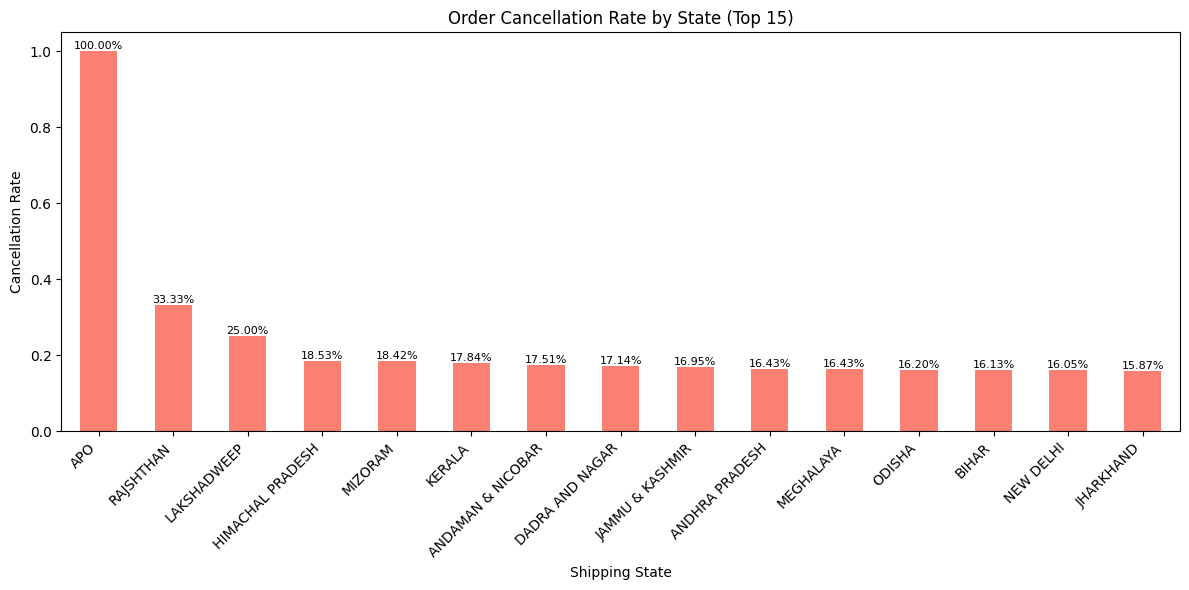

In [16]:
# calculate cancel rate by states
state_rate = (
    df.groupby('ship-state')['is_cancelled']
      .mean()                    # mean of boolean = rate
      .sort_values(ascending=False)
      .head(15)
)

# plot the rate with data labels
fig, ax = plt.subplots(figsize=(12,6))
state_rate.plot(kind='bar', color='salmon', ax=ax)
# annotate each bar with its percentage value
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.2f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=8)

plt.title('Order Cancellation Rate by State (Top 15)')
plt.xlabel('Shipping State')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

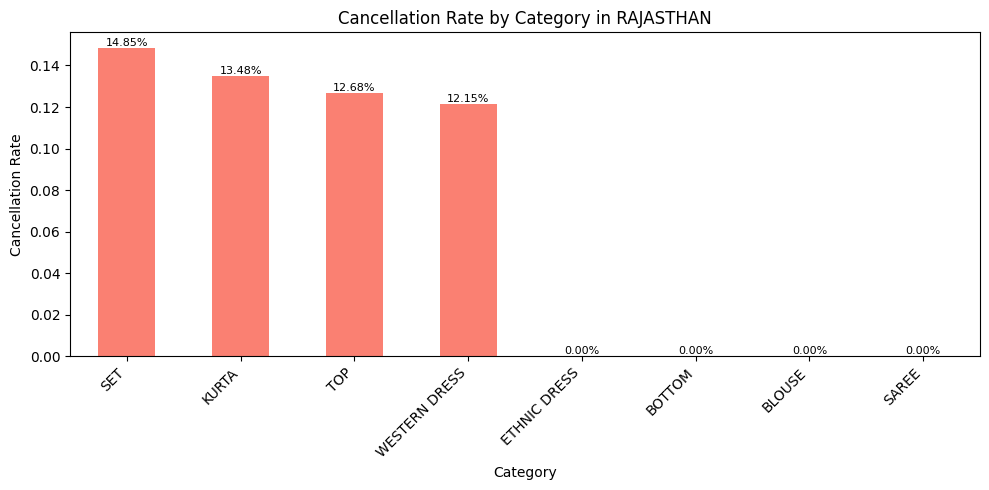

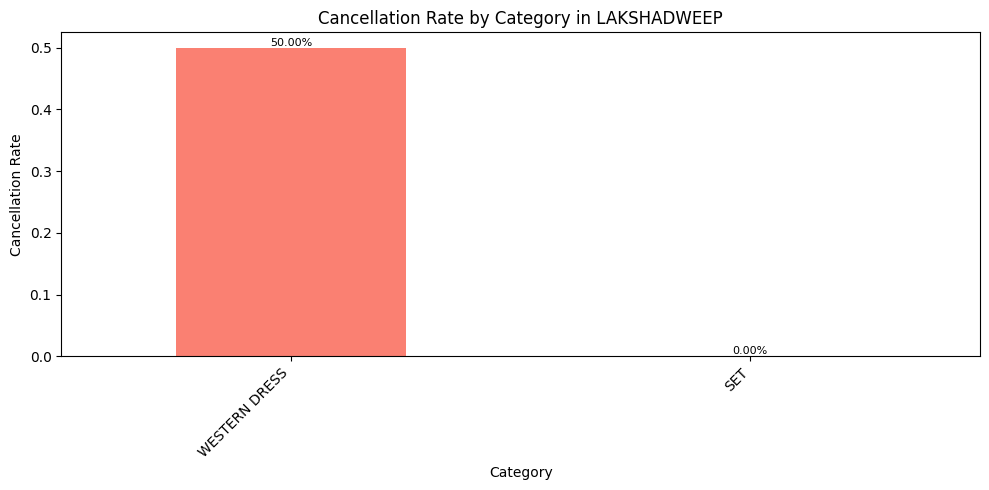

In [17]:
# show cancellation rate by Category for each state
for state in ['RAJASTHAN', 'LAKSHADWEEP']:
    df_state = df[df['ship-state'] == state]
    if df_state.empty:
        continue

    cat_rate = (
        df_state.groupby('Category')['is_cancelled']
                .mean()
                .sort_values(ascending=False)
    )

    fig, ax = plt.subplots(figsize=(10,5))
    cat_rate.plot(kind='bar', color='salmon', ax=ax)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()*100:.2f}%',
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)
    plt.title(f'Cancellation Rate by Category in {state}')
    plt.xlabel('Category')
    plt.ylabel('Cancellation Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

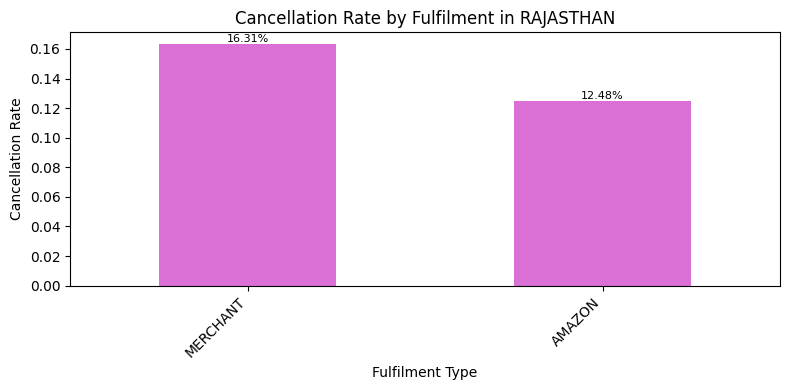

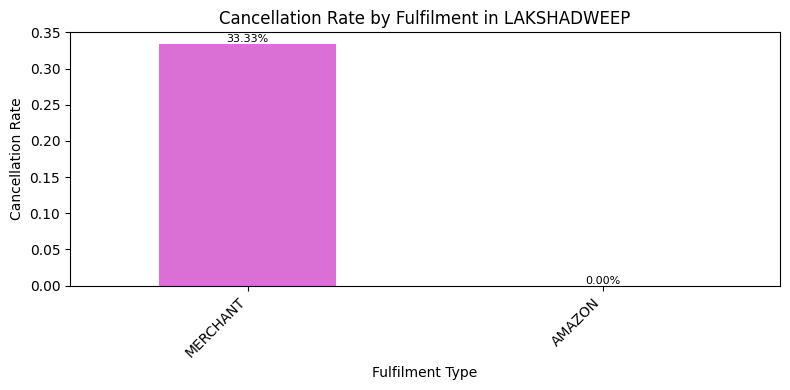

In [18]:
# relationship between fulfilment type and cancelled order rate for the two states
for state in ['RAJASTHAN', 'LAKSHADWEEP']:
    df_state = df[df['ship-state'] == state]
    if df_state.empty:
        continue
    fulfil_rate = df_state.groupby('Fulfilment')['is_cancelled'].mean().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(8,4))
    fulfil_rate.plot(kind='bar', color='orchid', ax=ax)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()*100:.2f}%',
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)
    plt.title(f'Cancellation Rate by Fulfilment in {state}')
    plt.xlabel('Fulfilment Type')
    plt.ylabel('Cancellation Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

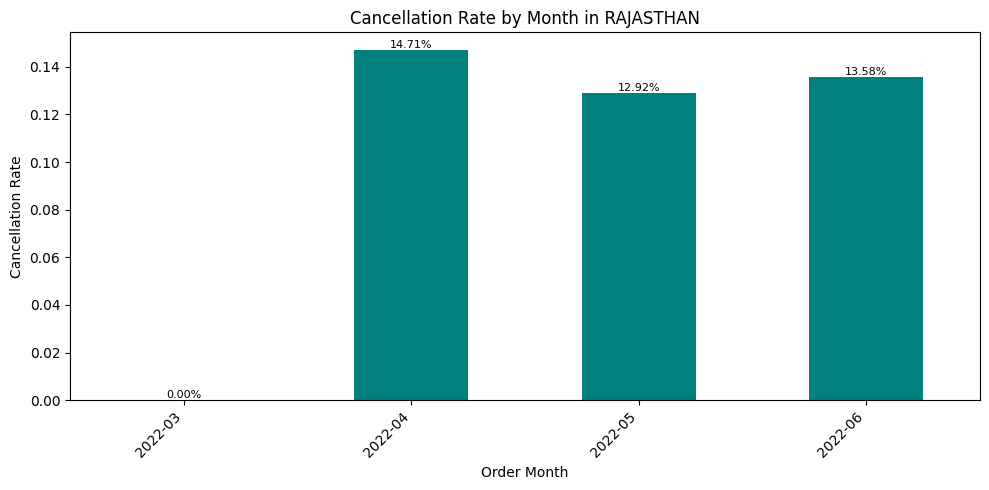

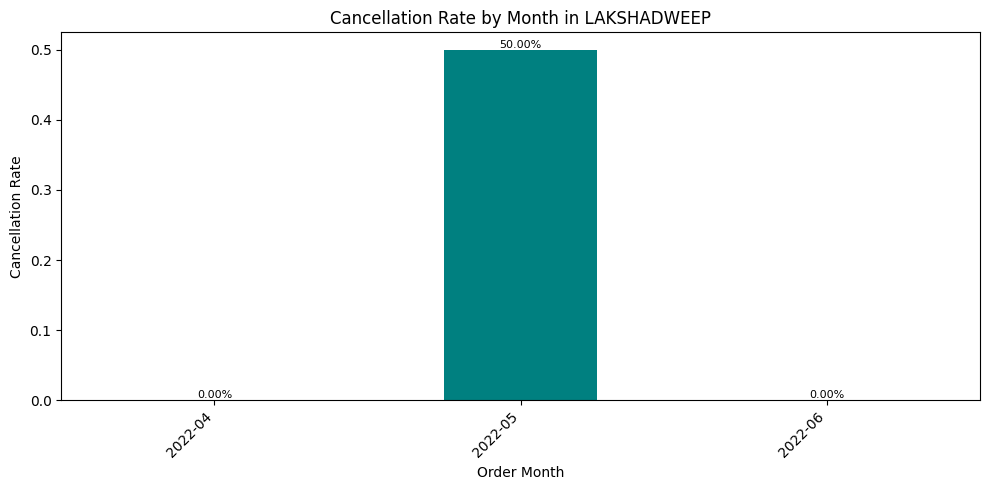

In [19]:
# relationship between order_month and cancelled order rate for the two states
for state in ['RAJASTHAN', 'LAKSHADWEEP']:
    df_state = df[df['ship-state'] == state]
    if df_state.empty:
        continue
    month_rate = df_state.groupby('order_month')['is_cancelled'].mean().sort_index()

    fig, ax = plt.subplots(figsize=(10,5))
    month_rate.plot(kind='bar', color='teal', ax=ax)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()*100:.2f}%',
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)
    plt.title(f'Cancellation Rate by Month in {state}')
    plt.xlabel('Order Month')
    plt.ylabel('Cancellation Rate')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

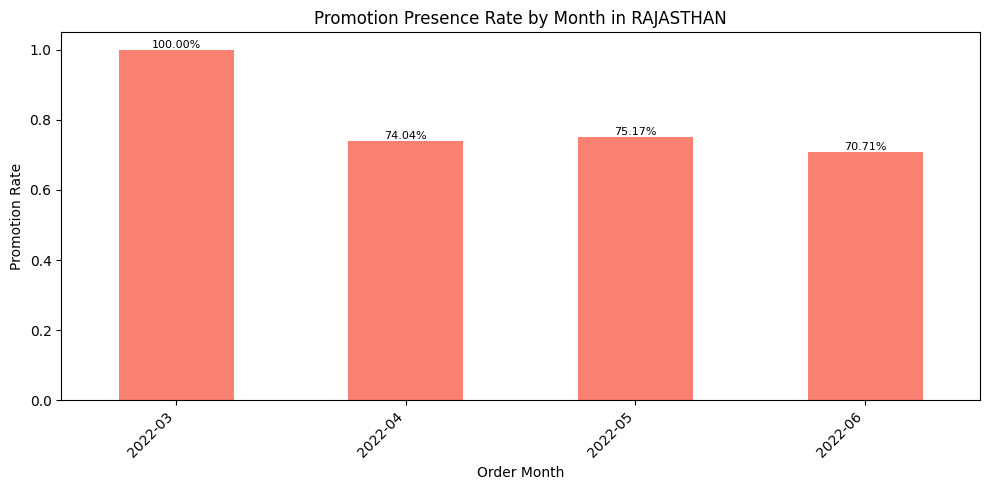

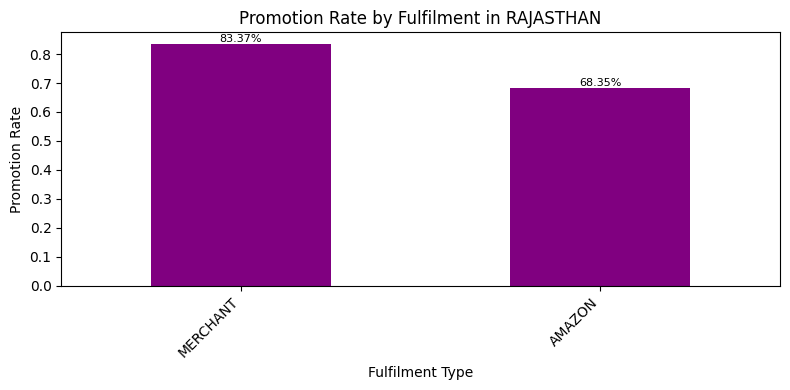

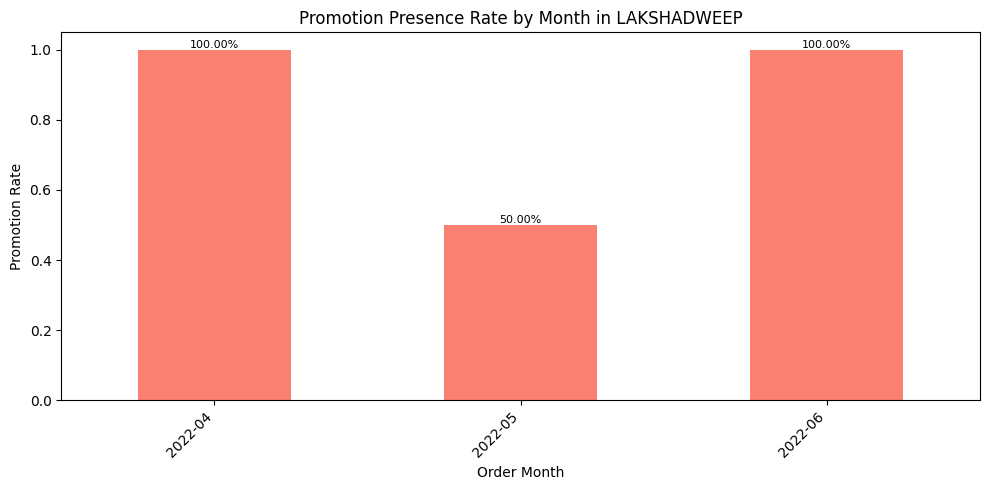

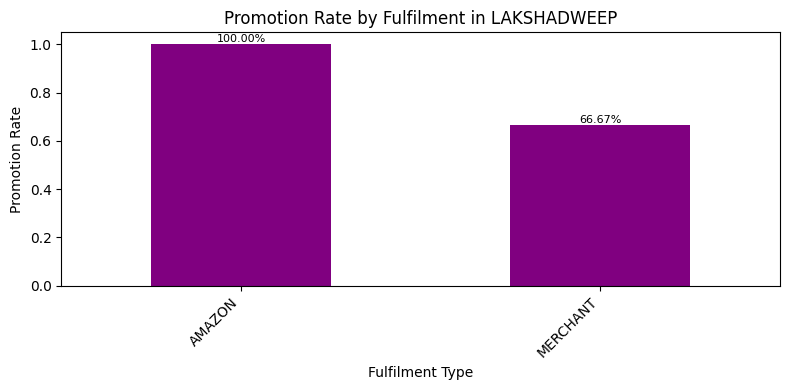

In [20]:
    # now promotion rate by month based on promotion_ids (presence of any promo)

    for state in ['RAJASTHAN', 'LAKSHADWEEP']:
        df_state = df[df['ship-state'] == state]  # avoid SettingWithCopyWarning
        # ensure correct column and count promotions
        df_state['has_promotion'] = df_state['promotion-ids'].fillna('').astype(str).str.strip() != ''
        promo_rate = df_state.groupby('order_month')['has_promotion'].mean().sort_index()
        fig, ax = plt.subplots(figsize=(10,5))
        promo_rate.plot(kind='bar', color='salmon', ax=ax)
        for p in ax.patches:
            ax.annotate(f'{p.get_height()*100:.2f}%',
                        (p.get_x() + p.get_width()/2, p.get_height()),
                        ha='center', va='bottom', fontsize=8)
        plt.title(f'Promotion Presence Rate by Month in {state}')
        plt.xlabel('Order Month')
        plt.ylabel('Promotion Rate')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # promotion rate by fulfilment type
        fulfil_promo_rate = df_state.groupby('Fulfilment')['has_promotion'].mean().sort_values(ascending=False)
        fig, ax = plt.subplots(figsize=(8,4))
        fulfil_promo_rate.plot(kind='bar', color='purple', ax=ax)
        for p in ax.patches:
            ax.annotate(f'{p.get_height()*100:.2f}%',
                        (p.get_x() + p.get_width()/2, p.get_height()),
                        ha='center', va='bottom', fontsize=8)
        plt.title(f'Promotion Rate by Fulfilment in {state}')
        plt.xlabel('Fulfilment Type')
        plt.ylabel('Promotion Rate')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # This means that merchants are aggressively promoting their products through promotions even though their fulfillment
    # is poor, causing customers to cancel their orders before they arrive.

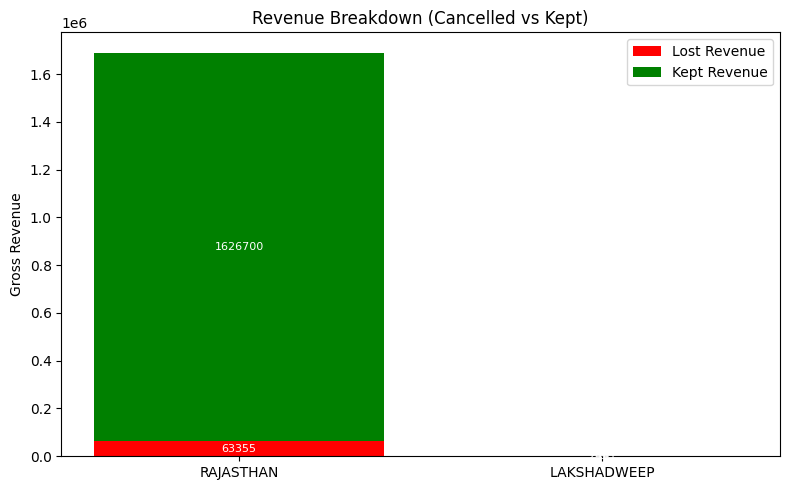

RAJASTHAN: lost=63355, total=1690055, pct_loss=3.75%
LAKSHADWEEP: lost=0, total=2441, pct_loss=0.00%


In [21]:
# revenue loss analysis for specified states
states = ['RAJASTHAN', 'LAKSHADWEEP']
# total revenue by state
state_total = df.groupby('ship-state')['gross_revenue'].sum().reindex(states).fillna(0)
# revenue lost from cancelled orders
state_lost = df[df['is_cancelled']].groupby('ship-state')['gross_revenue'].sum().reindex(states).fillna(0)
state_kept = state_total - state_lost

# stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(states, state_lost, label='Lost Revenue', color='red')
ax.bar(states, state_kept, bottom=state_lost, label='Kept Revenue', color='green')
for i, st in enumerate(states):
    ax.text(i, state_lost.iloc[i]/2, f'{state_lost.iloc[i]:.0f}', ha='center', va='center', color='white', fontsize=8)
    ax.text(i, state_lost.iloc[i] + state_kept.iloc[i]/2, f'{state_kept.iloc[i]:.0f}', ha='center', va='center', color='white', fontsize=8)

plt.title('Revenue Breakdown (Cancelled vs Kept)')
plt.ylabel('Gross Revenue')
plt.legend()
plt.tight_layout()
plt.show()

# print summary percentages
for st in states:
    pct = (state_lost[st] / state_total[st] * 100) if state_total[st] else 0
    print(f"{st}: lost={state_lost[st]:.0f}, total={state_total[st]:.0f}, pct_loss={pct:.2f}%")

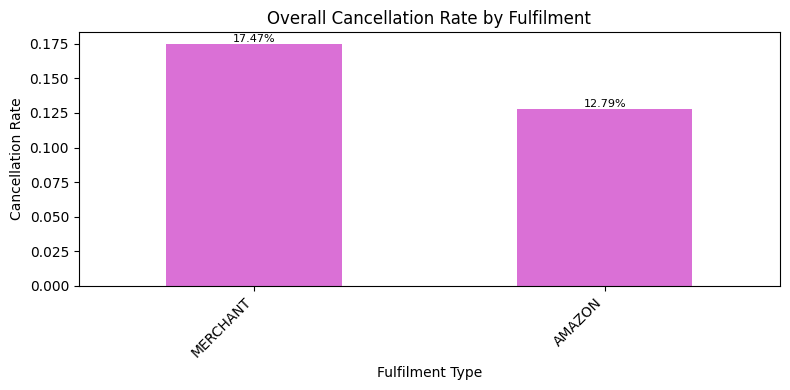

In [22]:

# overall cancellation rate by Fulfilment for entire dataset
overall_fulfil = (
    df.groupby('Fulfilment')['is_cancelled']
      .mean()
      .sort_values(ascending=False)
)
fig, ax = plt.subplots(figsize=(8,4))
overall_fulfil.plot(kind='bar', color='orchid', ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.2f}%',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=8)
plt.title('Overall Cancellation Rate by Fulfilment')
plt.xlabel('Fulfilment Type')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
